## This notebook generates LOS models for NH facilityfacts files ##

In [1]:
import os
import pandas as pd
from IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, lognorm
import scipy.optimize as op
from stats import fullCRVFromPDFModel, CachedCDFGenerator
import tools_util as tu
import pyrheautils as pu

## Load the model ##

In [2]:
runDesc = '/home/welling/git/pyRHEA_github/src/sim/twoyear_allfac_OC.yaml'
inputDict = tu.readModelInputs(runDesc)
pu.prepPathTranslations(inputDict)
facDict = tu.getFacDict(inputDict)


## Load the line list data ##

In [3]:
lineDF = pd.read_csv(pu.pathTranslate('$(MODELDIR)/'
                                     'OC_Nursing_Home_LOS_Line-Lists_for_RHEA_2.0_-_2011-2015_-_Adult_Only_-_06-10-2019_UPDATE_NH_LOS_Line_List.csv'))

#                                      'OC_Nursing_Home_LOS_Line-Lists_for_RHEA_2.0_-_2011-2015_-_Adult_Only_-_05-21-2019_UPDATE_v2_NH_LOS_Line_List.csv'))
print lineDF.columns
lineDF = lineDF[lineDF['NOT YET DISCHARGED?'].isnull()]
display(lineDF.head())

Index([u'NH CODE', u'DISCHARGE/ASSESSMENT YEAR', u'RAW LOS (days)',
       u'NOT YET DISCHARGED?', u'ADD 45 DAYS?', u'ADJUSTED LOS (days)'],
      dtype='object')


,NH CODE,DISCHARGE/ASSESSMENT YEAR,RAW LOS (days),NOT YET DISCHARGED?,ADD 45 DAYS?,ADJUSTED LOS (days)
0,ALAM,2012,12,NaN,NaN,12
1,ALAM,2012,19,NaN,NaN,19
2,ALAM,2014,10,NaN,NaN,10
3,ALAM,2012,41,NaN,NaN,41
4,ALAM,2011,5,NaN,NaN,5


## Some Useful Functions ##

Also, make the plots big enough to see

In [10]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
#plt.rcParams["figure.figsize"] = [16, 10]
plt.rcParams["figure.figsize"] = [8, 5]

In [5]:
def pltCRV(crv, scale=1.0, label=None, xlim=None):
    mv = crv.mean()
    if xlim is None:
        xV = np.linspace(0.0, round(3*mv), 101)
    else:
        xV = np.linspace(0.0, xlim, 101)
    yV = scale * crv.pdf(xV)
    if label is None:
        plt.plot(xV, yV, '-')
    else:
        plt.plot(xV, yV, '-', label=label)
    plt.plot([mv], [0.0], '*')
    print mv


In [6]:
def chisqr(crv, samps, highBound, col='RAW LOS (days)', codeCol='NH CODE'):
    sampV = np.zeros(highBound)
    for val in samps[col]:
        if int(val) < highBound:
            sampV[int(val)] += 1
    totSamps = samps[samps[col] <= highBound][codeCol].count()
    scale = totSamps / crv.cdf(highBound)
    predV = crv.pdf(np.linspace(0, highBound - 1, highBound) + 0.5) * scale
    diffV = sampV - predV
    rslt = np.sqrt((diffV * diffV).sum())
    return rslt

def buildLOSModel(estV, disch, tto, meanPop):
    assert len(estV) == 2, 'was expecting two parameters?'
    alpha = float(disch - tto)/float(disch)
    ttoRate = float(tto)/(365. * meanPop)
    losModel = {'parms': [alpha, estV[0], estV[1], ttoRate],
                'pdf': "$0*lognorm(mu=$1,sigma=$2)+(1-$0)*expon(lambda=$3)"}
    return losModel


def calcChiSqr(estV, disch, tto, meanPop, sampDF, col='RAW LOS (days)', codeCol='NH CODE'):
    losModel = buildLOSModel(estV, disch, tto, meanPop)
    crv = fullCRVFromPDFModel(losModel)
    rslt = chisqr(crv, facLOSDF, 365, col=col, codeCol=codeCol)
    #print '%s -> %s' % (losModel, rslt)
    return rslt




In [7]:
def estLogNormParms(losDF, col='RAW LOS (days)'):
    lnSampV = np.log(losDF[col].values)
    mu = np.average(lnSampV)
    sigma = np.std(lnSampV)
    return [mu, sigma]
    

## Estimate fit values for all NHs ##

In [8]:
fitD = {}
abbrevL = [abbrev for abbrev, rec in facDict.items() if rec['category']=='NURSINGHOME']
for abbrev in abbrevL:
    facLOSDF = lineDF[lineDF['NH CODE'] == abbrev]
    guessV = estLogNormParms(facLOSDF)
    facRec = facDict[abbrev]
    tto = 0.0
    for elt in facRec['totalTransfersOut']:
        tto += elt['count']['value']
    meanPop = facRec['meanPop']['value']
    disch = facRec['totalDischarges']['value']
    rslt = op.minimize(calcChiSqr, guessV, args=(disch, tto, meanPop, facLOSDF), method='Nelder-Mead')
    fitLOSModel = buildLOSModel(rslt.x, disch, tto, meanPop)
    nLines = facLOSDF.count()['NH CODE']
    nSamps = facLOSDF[facLOSDF['RAW LOS (days)'] <= 365]['NH CODE'].count()
    fitLOSModel['nsamples'] = nSamps
    fitLOSModel['chisqr_per_sample'] = rslt.fun / nSamps
    fitLOSModel['converged'] = rslt.success
    fitD[abbrev] = fitLOSModel
    print '%s: %s' % (abbrev, fitLOSModel)


CSNC: {'chisqr_per_sample': 0.03495585512085629, 'pdf': '$0*lognorm(mu=$1,sigma=$2)+(1-$0)*expon(lambda=$3)', 'converged': True, 'nsamples': 1501, 'parms': [0.48760000000000003, 2.6453123966488867, 0.7816010828175939, 0.004194893410067277]}
LPAL: {'chisqr_per_sample': 0.035863707398563725, 'pdf': '$0*lognorm(mu=$1,sigma=$2)+(1-$0)*expon(lambda=$3)', 'converged': True, 'nsamples': 1501, 'parms': [0.6265999999999999, 2.7624043890099643, 0.7729822604051335, 0.004591365828354052]}
MANO: {'chisqr_per_sample': 0.03144315861320606, 'pdf': '$0*lognorm(mu=$1,sigma=$2)+(1-$0)*expon(lambda=$3)', 'converged': True, 'nsamples': 7000, 'parms': [0.7653000000000001, 2.6079386160945903, 0.5343893928767662, 0.005981716254561629]}
COVI: {'chisqr_per_sample': 0.04820472885978475, 'pdf': '$0*lognorm(mu=$1,sigma=$2)+(1-$0)*expon(lambda=$3)', 'converged': True, 'nsamples': 1823, 'parms': [0.8057, 3.027776707176837, 0.4208343656627289, 0.008333290366429569]}
CVSB: {'chisqr_per_sample': 0.025987996688825264, '

## Plot a random sampling as examples ##

['NEWO']
55.82061595818493


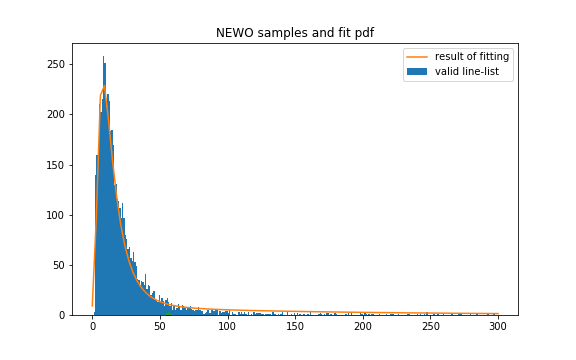

In [12]:
#showL = np.random.choice(abbrevL, size=10)
showL = ['NEWO']
print showL

for abbrev in showL:
    fitCRV = fullCRVFromPDFModel(fitD[abbrev])
    facLOSDF = lineDF[lineDF['NH CODE'] == abbrev]
    plt.hist(facLOSDF['RAW LOS (days)'], range=(0,300), bins=300, label='valid line-list')
    nLines = facLOSDF.count()['NH CODE']
    pltCRV(fitCRV, scale=nLines/fitCRV.cdf(365.), label='result of fitting', xlim=300)
    plt.legend()
    #plt.title('%s %s' % (abbrev, fitLOSModel['parms']))
    plt.title('%s samples and fit pdf' % abbrev)
    plt.show()

## Look at the cases where fitting failed ##

In [ ]:
showL = [abbrev for abbrev, rec in fitD.items() if not rec['converged']]
print showL

for abbrev in showL:
    fitCRV = fullCRVFromPDFModel(fitD[abbrev])
    facLOSDF = lineDF[lineDF['NH CODE'] == abbrev]
    display(facLOSDF.head())
    plt.hist(facLOSDF['RAW LOS (days)'], range=(0,300), bins=300, label='valid line-list')
    nLines = facLOSDF.count()['NH CODE']
    pltCRV(fitCRV, scale=nLines/fitCRV.cdf(365.), label='result of fitting', xlim=300)
    plt.legend()
    plt.title('%s %s' % (abbrev, fitLOSModel['parms']))
    plt.show()

## Save the fit models ##

In [ ]:
orecL = []
for abbrev, rec in fitD.items():
    orec = {('parms{}'.format(i)) : v for i, v in enumerate(rec['parms'])}
    orec.update({'abbrev': abbrev, 'pdf': rec['pdf'], 'nsamples': rec['nsamples'],
                 'chisqr_per_sample': rec['chisqr_per_sample']})
    orecL.append(orec)
odf = pd.DataFrame(orecL)
odf = odf.sort_values(['abbrev'], axis=0)
odf.to_csv('los_model_fit_nh_split_fates.csv', index=False)

## Analytical Model ##

How do we map these fits into a partition between FRAIL and non-FRAIL patients?  The notion is that all patients are subject to the exponential term, which represents spontaneous problems requiring hospitalization.  Only non-FRAIL patients are subject to the lognorm term, which represents the completion of rehab and is followed by a return to the community.

$$
P = \lambda (\alpha P_H + (1 - \alpha)P_t) + (1 - \lambda)P_t
$$

$$
P = \lambda \alpha P_H + \{ \lambda (1-\alpha) + (1 - \lambda) \} P_t
$$

$$
\hat{\alpha} = \lambda \alpha \\
1 - \hat{\alpha} = \lambda (1-\alpha) + (1 - \lambda)
$$

* $P$ is total discharge probability for a patient (known)
* $P_H$ is probability of discharge home (known)
* $P_t$ is probability of transfer to another facility (known)
* $N$ is total discharges per year (known)
* $n$ is total transfers per year (known)
* $\lambda$ is the fraction *not* frail
* $\alpha$ is the weight of the lognormal term in the non-frail PDF
* $\hat{\alpha}$ is the weight of the lognormal term in the overall PDF

It looks like a perfectly valid solution is $\lambda = a = \sqrt{\hat{a}}$ .

In [ ]:
for abbrev in ['NEWO']:
    losModel = fitD[abbrev]
    losCRV = fullCRVFromPDFModel(losModel)
    homeLOSModel = {'parms': losModel['parms'][1:3], 'pdf': 'lognorm(mu=$0,sigma=$1)'}
    homeCRV = fullCRVFromPDFModel(homeLOSModel)
    transLOSModel = {'parms': losModel['parms'][3:], 'pdf': 'expon(lambda=$0)'}
    transCRV = fullCRVFromPDFModel(transLOSModel)
    facLOSDF = lineDF[lineDF['NH CODE'] == abbrev]
    print 'a-hat: ', losModel['parms'][0:1]
    print 'full: ', 1.0 - losCRV.cdf(365.)
    print 'home: ', 1.0 - homeCRV.cdf(365.)
    print 'trans: ', 1.0 - transCRV.cdf(365.)
    ratio = float(facLOSDF[facLOSDF['RAW LOS (days)'] >= 365.].count()['NH CODE'])/float(facLOSDF.count()['NH CODE'])
    print 'by count: ', ratio

## Read and plot intervalprob values captured by JournalingCachedCDFGenerator ##

In [ ]:
simDF = pd.read_msgpack(pu.pathTranslate('$(SIMDIR)/cdf_intervalprob_results.mpz'))
#display(simDF.head())
for abbrev in simDF['abbrev'].unique():
    print abbrev
    df = simDF[simDF.abbrev == abbrev]
    #display(df.head())
    for pdf in df['pdf'].unique():
        print pdf
        subDF = df[df.pdf == pdf]
        display(subDF.tail())
        plt.plot(0.5*(subDF['start'] + subDF['end']), subDF['rslt'], '*', alpha=0.01, label=pdf)
    plt.xlim(0.0, 300.0)
    plt.title(abbrev)
    plt.legend()
    plt.show()
    

## Some experiments in storing samples as yaml ##

In [65]:
from collections import defaultdict
facLOSDF = lineDF[lineDF['NH CODE'] == 'NEWO']
sampDF = facLOSDF['RAW LOS (days)']
dct = defaultdict(int)
for elt in sampDF:
    dct[elt] += 1
dct = {k: v for k, v in dct.items()}
print dct

   

{1: 3, 2: 140, 3: 159, 4: 167, 5: 210, 6: 202, 7: 215, 8: 258, 9: 251, 10: 207, 11: 220, 12: 213, 13: 183, 14: 184, 15: 169, 16: 130, 17: 131, 18: 116, 19: 114, 20: 107, 21: 97, 22: 112, 23: 97, 24: 80, 25: 76, 26: 66, 27: 68, 28: 57, 29: 54, 30: 63, 31: 53, 32: 49, 33: 36, 34: 35, 35: 29, 36: 34, 518: 1, 38: 30, 39: 41, 40: 26, 41: 30, 42: 29, 43: 20, 44: 22, 45: 24, 46: 16, 47: 14, 48: 13, 520: 1, 50: 13, 51: 17, 52: 14, 53: 9, 54: 15, 55: 17, 56: 13, 57: 9, 58: 12, 59: 5, 60: 9, 61: 5, 62: 7, 63: 11, 64: 9, 65: 5, 66: 10, 67: 9, 1025: 1, 69: 5, 70: 7, 71: 7, 72: 9, 73: 6, 74: 5, 75: 4, 588: 1, 77: 5, 78: 8, 79: 5, 80: 4, 81: 4, 82: 1, 83: 2, 84: 3, 85: 5, 86: 2, 87: 2, 88: 5, 89: 4, 90: 4, 1551: 1, 604: 1, 605: 1, 606: 1, 95: 2, 96: 3, 97: 3, 98: 4, 99: 4, 100: 2, 101: 5, 103: 3, 104: 1, 105: 1, 1127: 1, 108: 3, 109: 1, 110: 3, 111: 1, 112: 3, 113: 1, 115: 3, 117: 1, 119: 3, 120: 1, 121: 2, 122: 2, 123: 2, 124: 2, 125: 1, 126: 1, 128: 1, 129: 1, 1154: 1, 131: 1, 133: 3, 134: 1, 135:

In [66]:
#shortHS = pd.Series(losHV)
mystr = json.dumps(dct)
print 'length: ', len(mystr)
print mystr


length:  2623
{"1": 3, "2": 140, "3": 159, "4": 167, "5": 210, "6": 202, "7": 215, "8": 258, "9": 251, "10": 207, "11": 220, "12": 213, "13": 183, "14": 184, "15": 169, "16": 130, "17": 131, "18": 116, "19": 114, "20": 107, "21": 97, "22": 112, "23": 97, "24": 80, "25": 76, "26": 66, "27": 68, "28": 57, "29": 54, "30": 63, "31": 53, "32": 49, "33": 36, "34": 35, "35": 29, "36": 34, "518": 1, "38": 30, "39": 41, "40": 26, "41": 30, "42": 29, "43": 20, "44": 22, "45": 24, "46": 16, "47": 14, "48": 13, "520": 1, "50": 13, "51": 17, "52": 14, "53": 9, "54": 15, "55": 17, "56": 13, "57": 9, "58": 12, "59": 5, "60": 9, "61": 5, "62": 7, "63": 11, "64": 9, "65": 5, "66": 10, "67": 9, "1025": 1, "69": 5, "70": 7, "71": 7, "72": 9, "73": 6, "74": 5, "75": 4, "588": 1, "77": 5, "78": 8, "79": 5, "80": 4, "81": 4, "82": 1, "83": 2, "84": 3, "85": 5, "86": 2, "87": 2, "88": 5, "89": 4, "90": 4, "1551": 1, "604": 1, "605": 1, "606": 1, "95": 2, "96": 3, "97": 3, "98": 4, "99": 4, "100": 2, "101": 5

In [69]:
import json
dct = json.loads(mystr)
idct = {}
maxK = 0
for k, v in dct.items():
    ik = int(k)
    idct[ik] = v
    maxK = max(maxK, ik)
print maxK
print idct


4838
{1025: 1, 2: 140, 3: 159, 4: 167, 5: 210, 518: 1, 7: 215, 8: 258, 521: 1, 10: 207, 11: 220, 12: 213, 13: 183, 14: 184, 1551: 1, 16: 130, 17: 131, 18: 116, 2051: 1, 20: 107, 21: 97, 22: 112, 23: 97, 24: 80, 25: 76, 26: 66, 27: 68, 28: 57, 29: 54, 30: 63, 31: 53, 32: 49, 33: 36, 34: 35, 35: 29, 36: 34, 37: 33, 38: 30, 39: 41, 552: 1, 604: 1, 42: 29, 43: 20, 44: 22, 45: 24, 1070: 1, 47: 14, 48: 13, 520: 1, 50: 13, 51: 17, 52: 14, 53: 9, 54: 15, 55: 17, 56: 13, 57: 9, 58: 12, 59: 5, 60: 9, 573: 1, 62: 7, 63: 11, 64: 9, 65: 5, 66: 10, 67: 9, 68: 7, 69: 5, 70: 7, 71: 7, 72: 9, 73: 6, 74: 5, 75: 4, 588: 1, 77: 5, 78: 8, 79: 5, 80: 4, 81: 4, 82: 1, 83: 2, 596: 1, 85: 5, 86: 2, 87: 2, 88: 5, 89: 4, 90: 4, 91: 6, 92: 5, 605: 1, 94: 4, 95: 2, 96: 3, 97: 3, 98: 4, 99: 4, 100: 2, 101: 5, 1127: 1, 104: 1, 105: 1, 103: 3, 108: 3, 109: 1, 110: 3, 111: 1, 112: 3, 113: 1, 115: 3, 117: 1, 119: 3, 120: 1, 121: 2, 122: 2, 123: 2, 124: 2, 125: 1, 126: 1, 128: 1, 129: 1, 130: 1, 131: 1, 133: 3, 134: 1, 

In [72]:
arr = np.zeros(maxK+1, dtype=np.int)
for k, v in idct.items():
    arr[k] = v
print len(arr)
print arr

4839
[  0   3 140 ...   0   0   1]


In [74]:
sumArr = np.cumsum(arr)
print len(sumArr)
print sumArr

4839
[   0    3  143 ... 5241 5241 5242]


In [75]:
def intervalprob(day, sumArr):
    if day < len(sumArr):
        prevCt = 0 if day == 0 else sumArr[day-1]
        delta = sumArr[day] - prevCt
    else:
        prevCt = 0
        delta = 0
    return float(delta) / float(sumArr[-1] - prevCt)

In [76]:
print intervalprob(37, sumArr)

0.0385064177363


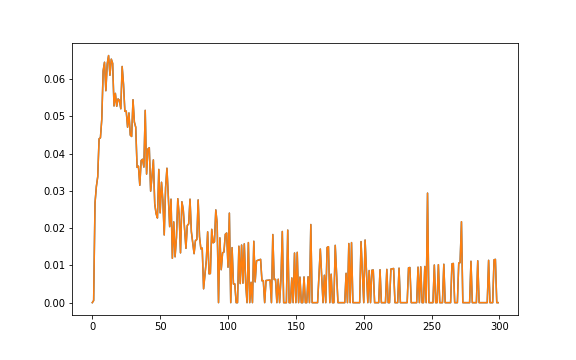

In [83]:
xV = np.arange(0.0, 300.0, 1.0)
yV = [intervalprob(int(x), sumArr) for x in xV]
plt.plot(xV, yV, '-')
plt.show()